# **EDA Sơ bộ (trước khi Pre-processing)**

### **Import Libraries**

In [2]:
import re
import math
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from scipy.stats import entropy

### **Load data**

In [3]:
df = pd.read_csv('../Data/data_full_crawl_balanced.csv')

In [128]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### **Kiểm tra tổng quan (Overview)**

#### Xem cấu trúc

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68000 entries, 0 to 67999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      68000 non-null  object
 1   source    68000 non-null  object
 2   title     68000 non-null  object
 3   content   68000 non-null  object
 4   category  68000 non-null  object
 5   url       68000 non-null  object
dtypes: object(6)
memory usage: 3.1+ MB


In [90]:
df.columns

Index(['date', 'source', 'title', 'content', 'category', 'url'], dtype='object')

In [91]:
df.head(5)

,date,source,title,content,category,url
0,6/10/2025,VnExpress,Nha Trang có thêm dự án nhà ở xã hội hơn 1.100...,UBND tỉnh Khánh Hòa vừa ban hành quyết định ch...,Bất động sản,https://vnexpress.net/nha-trang-co-them-du-an-...
1,19/11/2025,VnExpress,Đề xuất Nhà nước thu hồi đất khi một nửa chủ s...,"Quan điểm này được ông Đỗ Đức Hồng Hà, Phó chủ...",Bất động sản,https://vnexpress.net/de-xuat-nha-nuoc-thu-hoi...
2,26/10/2025,VnExpress,Xu hướng dùng nội thất inox trong thiết kế khô...,"Với đặc tính chống gỉ, chịu lực, dễ vệ sinh và...",Bất động sản,https://vnexpress.net/xu-huong-dung-noi-that-i...
3,18/8/2025,VnExpress,Cải tạo căn hộ 48 m2 cho 3 người ở với 280 tri...,"Căn hộ có diện tích 48 m2, tọa lạc tại một tòa...",Bất động sản,https://vnexpress.net/cai-tao-can-ho-48-m2-cho...
4,31/10/2025,VnExpress,Thu ngân sách TP HCM vượt cùng kỳ nhờ đất đai,Thông tin được Phó giám đốc Sở Tài chính TP HC...,Bất động sản,https://vnexpress.net/thu-ngan-sach-tp-hcm-vuo...


In [92]:
df.tail(5)

,date,source,title,content,category,url
67995,25/09/2025,VietNamNet,Người đàn ông bị kẹt đầu trong cột đèn 40 phút...,"Truyền thông địa phương đưa tin, vụ việc hy hữ...",Đời sống,https://vietnamnet.vn/nguoi-dan-ong-bi-ket-dau...
67996,8/10/2017,Báo Lao Động,Nộp tiền để được nghỉ việc!,Vốn là người chấp nhận bồi thường tiền cho chủ...,Đời sống,https://laodong.vn/lao-dong-doi-song/nop-tien-...
67997,9/9/2017,Báo Lao Động,TPHCM: Siết chặt cấp phép dự án “cứu” hạ tầng,Chung cư ở trong hẻm Mặc dù khi phê duyệt các ...,Đời sống,https://laodong.vn/lao-dong-doi-song/tphcm-sie...
67998,13/08/2025,VietNamNet,"Ly hôn vẫn phải ở chung vì chưa bán được nhà, ...","Trước khi quyết định ly hôn, tôi và chồng đã t...",Đời sống,https://vietnamnet.vn/ly-hon-van-phai-o-chung-...
67999,15/08/2025,VietNamNet,"7 người vào nhà hàng chỉ gọi 1 bát mì, chủ quá...",Sự việc xảy ra tại một quán mì nhỏ ở Trịnh Châ...,Đời sống,https://vietnamnet.vn/7-nguoi-vao-nha-hang-chi...


### **Kiểm tra Missing Values**

In [130]:
df.isna().sum()

date        0
source      0
title       0
content     0
category    0
url         0
dtype: int64

#### Kiểm tra duplicate

In [131]:
df.duplicated().sum()

np.int64(0)

Xóa Rác Tuyệt đối

In [132]:
df[['title', 'content']].duplicated().sum()

np.int64(0)

* Không có bài báo nào là bản sao lưu của nhau

Loại bỏ Bản sao

In [9]:
df['content'].duplicated().sum()

np.int64(0)

+ Không có bài báo nào có nội dung viết như nhau là sao lưu nội dung của nhau

Trùng Tiêu đề (Phân biệt)

In [10]:
df['title'].duplicated().sum()

np.int64(0)

- Không có trùng lặp bất kì bài báo nào

### **Kiểm tra nhiễu**

In [98]:
def check_noise_health(df, column_name='content'):
    print("=== BÁO CÁO TÌNH TRẠNG NHIỄU (DATA HEALTH CHECK) ===")
    total = len(df)
    
    html_pattern = r'<[^>]*>'          
    url_pattern = r'http[s]?://\S+'   
    js_pattern = r'function\s*\(|var\s+\w+\s*=' 
    email_pattern = r'\S*@\S*\.\S*'   
    
    html_count = df[column_name].str.contains(html_pattern, regex=True).sum()
    url_count = df[column_name].str.contains(url_pattern, regex=True).sum()
    js_count = df[column_name].str.contains(js_pattern, regex=True).sum()
    email_count = df[column_name].str.contains(email_pattern, regex=True).sum()
    
    print(f"- Tổng số bài viết: {total}")
    print(f"- Chứa thẻ HTML: {html_count} ({html_count/total*100:.2f}%)")
    print(f"- Chứa URL/Link: {url_count} ({url_count/total*100:.2f}%)")
    print(f"- Chứa Email:    {email_count} ({email_count/total*100:.2f}%)")
    print(f"- Nghi vấn Code: {js_count} ({js_count/total*100:.2f}%)")
    
    if (html_count + url_count) > 0:
        print("\nCần chạy lại regex cleaning kỹ hơn!")
    else:
        print("\nDữ liệu sạch sẽ.")

In [99]:
check_noise_health(df, 'content')

=== BÁO CÁO TÌNH TRẠNG NHIỄU (DATA HEALTH CHECK) ===
- Tổng số bài viết: 68000
- Chứa thẻ HTML: 7 (0.01%)
- Chứa URL/Link: 459 (0.68%)
- Chứa Email:    488 (0.72%)
- Nghi vấn Code: 1 (0.00%)

Cần chạy lại regex cleaning kỹ hơn!


In [8]:
def extract_noise_in_content(df, column_name='content'):
    html_pattern = r'<[^>]*>'
    url_pattern = r'http[s]?://\S+'
    js_pattern = r'function\s*\([^)]*\)\s*\{[^}]*\}|var\s+\w+\s*=\s*[^;]+;'
    email_pattern = r'\S+@\S+\.\S+'

    results = []

    for i, text in df[column_name].fillna("").items():
        noise_segments = []

        html_matches = re.findall(html_pattern, text)
        url_matches = re.findall(url_pattern, text)
        js_matches = re.findall(js_pattern, text)
        email_matches = re.findall(email_pattern, text)

        if html_matches:
            noise_segments.extend(html_matches)
        if url_matches:
            noise_segments.extend(url_matches)
        if js_matches:
            noise_segments.extend(js_matches)
        if email_matches:
            noise_segments.extend(email_matches)

        if noise_segments:
            noise_type = []
            if html_matches: noise_type.append("HTML")
            if url_matches: noise_type.append("URL")
            if js_matches: noise_type.append("JS")
            if email_matches: noise_type.append("EMAIL")

            results.append({
                "content": text,
                "noise_type": ", ".join(noise_type),
                "noise_found": noise_segments
            })

    return pd.DataFrame(results)


In [7]:
extract_noise_in_content(df, 'content')

,content,noise_type,noise_found
0,"Ngày 15/2, Chi nhánh Văn phòng đăng ký đất đai...",URL,[https://dichvucong.hochiminhcity.gov.vn.]
1,Các thiết kế tủ bếp của KitchenTown được nghiê...,URL,"[https://kitchentown.vn/, https://www.yoshimot..."
2,"Tiêu chí bền vững, thẩm mỹ và hiệu quả đầu tư ...",EMAIL,[vlxd@caslagroup.com]
3,"Dự án nằm tại trung tâm thành phố biển hồ, mở ...",EMAIL,[sales@masterisehomes.com]
4,The Fullhaus là mô hình clubhouse theo tiêu ch...,EMAIL,[tiktok.com/@thefullton.cld]
...,...,...,...
895,"Bước chân không run giữa Rừng SácNăm 1963, chà...",URL,[https://samngoclinhtruongtam.vn]
896,Tôi từng nghĩ hôn nhân của mình sẽ trọn vẹn nế...,EMAIL,[Bandoisong@vietnamnet.vn]
897,"Tôi năm nay 27 tuổi, mới kết hôn nửa năm. Sau ...",EMAIL,[Bandoisong@vietnamnet.vn]
898,Chồng tôi là giám đốc một công ty sản xuất đồ ...,EMAIL,[Bandoisong@vietnamnet.vn]


### **Loại bỏ các cột không cần thiết/không liên quan đến bài toán**

In [11]:
df.drop(columns=['date', 'source', 'url'], axis = 0 , inplace=True)

Các cốt sẽ loại bỏ:
- date: Chủ đề của một bài báo thường không phụ thuộc vào ngày tháng. Việc đưa thời gian vào có thể khiến mô hình học sai các quy luật mùa vụ không cần thiết cho việc phân loại.
- source: Đây là nguyên nhân dễ gây thiên kiến (Bias) lớn nhất.
- url: Đây là định danh duy nhất cho mỗi bài viết. Nó không mang ý nghĩa ngữ nghĩa tổng quát. Nếu đưa vào, mô hình sẽ bị nhiễu.

In [12]:
df.head(2)

,title,content,category
0,Nha Trang có thêm dự án nhà ở xã hội hơn 1.100...,UBND tỉnh Khánh Hòa vừa ban hành quyết định ch...,Bất động sản
1,Đề xuất Nhà nước thu hồi đất khi một nửa chủ s...,"Quan điểm này được ông Đỗ Đức Hồng Hà, Phó chủ...",Bất động sản


### **Kiểm tra độ cân bằng nhãn**

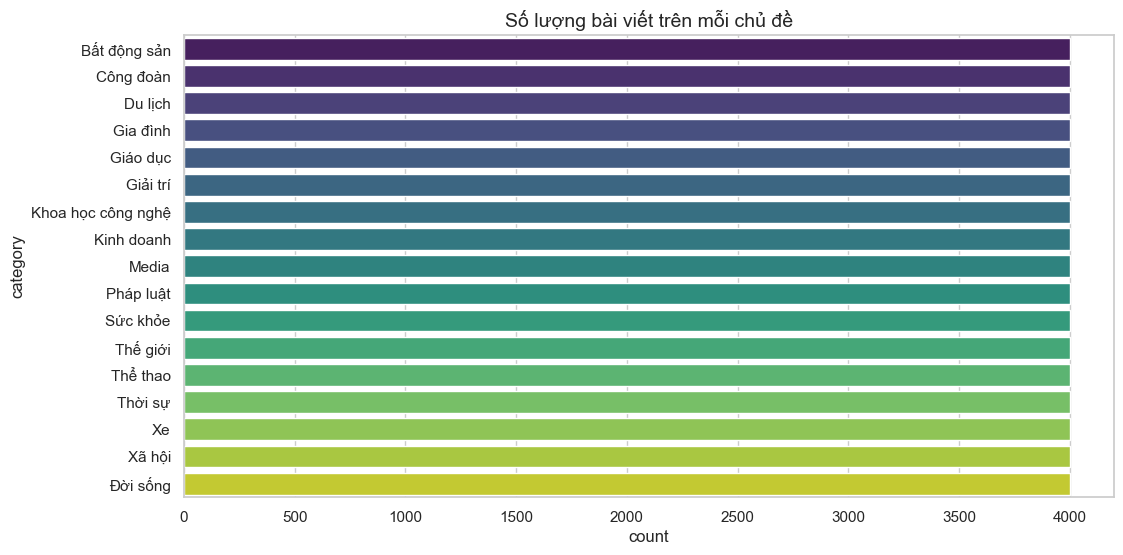

In [103]:
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df,hue = 'category', order=df['category'].value_counts().index, palette='viridis')
plt.title('Số lượng bài viết trên mỗi chủ đề', fontsize=14)
plt.show()

- Với 17 chủ đề có số lượng mẫu đồng đều (4000 mẫu / chủ đề), bộ dữ liệu đạt trạng thái cân bằng lý tưởng, giúp giảm thiểu rủi ro bias cho mô hình Classification.

#### Kiểm tra độ dài thô & Lọc rác

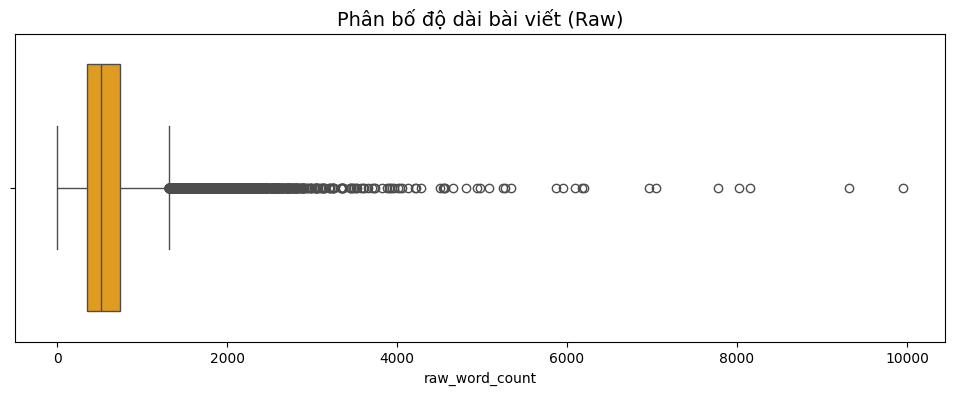

In [13]:
df['raw_word_count'] = df['content'].apply(lambda x: len(str(x).split()))

# Vẽ Boxplot để nhìn rõ outliers
plt.figure(figsize=(12, 4))
sns.boxplot(x=df['raw_word_count'], color='orange')
plt.title('Phân bố độ dài bài viết (Raw)', fontsize=14)
plt.show()

- Sự tập trung: Đa số bản tin có độ dài ngắn (< 1.000 từ), phản ánh đúng tính chất súc tích của tin tức hàng ngày.
- Giá trị ngoại lai: Xuất hiện đuôi dài với các bài viết lên tới từ 6000 - 10.000 từ, có thể là bài tổng hợp hoặc nhiễu.
- Quyết định xem xét loại bỏ các bài báo có số lượng từ < 50 và > 6000 có ảnh hưởng đến mô hình hoặc không có thông tin quan trong, không phải là bài báo
- Và áp dụng kỹ thuật cắt ngắn (truncation) ở các bước tiếp theo để phù hợp với giới hạn input của mô hình (như PhoBERT), tránh hiện tượng "data sparsity" hoặc quá tải bộ nhớ.

In [25]:
def check_article_length(df, column_name='content'):
    # BÀI QUÁ DÀI
    long_df = df[df['raw_word_count'] > 6000][[column_name, 'raw_word_count']]
    long_df = long_df.sort_values(by='raw_word_count', ascending=True)

    # BÀI QUÁ NGẮN
    short_df = df[df['raw_word_count'] <= 50][[column_name, 'raw_word_count']]
    short_df = short_df.sort_values(by='raw_word_count', ascending=True)

    return long_df, short_df

In [26]:
long_df, short_df = check_article_length(df, column_name='content')

In [28]:
print("=== BÀI QUÁ DÀI (>6000 từ) ===")
long_df

=== BÀI QUÁ DÀI (>6000 từ) ===


,content,raw_word_count
54344,"1. Vị trí, ý nghĩa, tầm quan trọng của công tá...",6094
19654,"Trước thực tế này, sáng 6.11, Báo Lao Động phố...",6180
41875,"- Tổng số trường hợp mắc: 17.390, trong đó tại...",6202
55401,Đã gần một thế kỷ nay (90 năm kể từ ngày có Đả...,6964
5102,11h: Kết thúc Lễ vinh danh 74 Doanh nghiệp vì ...,7051
43333,- 16 bệnh nhân mắc COVID-19 tính từ ngày 23.1 ...,7780
42881,- 16 bệnh nhân mắc COVID-19 tính từ ngày 23.1 ...,8018
54983,I- TÌNH HÌNH VÀ NGUYÊN NHÂN 1- Trong những nă...,8148
4207,"11h15: Đồng chí Phạm Thị Thanh Thuỷ, Phó Chủ t...",9322
43411,Theo báo cáo của hệ thống giám sát bệnh truyền...,9948


In [29]:
print("\n=== BÀI QUÁ NGẮN (<=50 từ) ===")
short_df


=== BÀI QUÁ NGẮN (<=50 từ) ===


,content,raw_word_count
21225,,0
1167,Song Anh,2
8074,Tâm Anh,2
67004,Chú ý,2
8233,Huyền Sâm,2
...,...,...
57326,Tôi phân vân chọn mua Mitsubishi Xforce hoặc V...,50
37348,Hà Nội quy định cụ thể việc này thế nào? Nếu k...,50
23016,"Theo lãnh đạo Cocoon, bên cạnh những mặt tích ...",50
27125,"Ngoài ra, có nhiều loại điều hòa mini, kích th...",50


- Sau khi xem thông tin nội dung của một bài báo có độ dài từ <=50 và >=6000 thì:
+ Quyết định giữ có bài báo có số lượng kí tự >=6000 Vì nó là bài báo có thể chứa các thông tin quan trọng cho mô hình. Nếu quá dài để đưa vào mô hình thì sẽ xử lý ở bước feature engineering.
+ Quyết định xoá các bài có số lượng từ  <= 50 vì các bài đó không mang thông tin bổ ích gì mà còn kèm theo các kí từ nhiễu.

In [106]:
# Quyết định lọc (Bỏ bài dưới 50 từ)
df = df[(df['raw_word_count'] > 50)].copy()
print(f"Số lượng mẫu còn lại sau khi lọc rác: {len(df)}")

Số lượng mẫu còn lại sau khi lọc rác: 67159


### **Lưu lại dataset đã được lọc các outlier và xử lí dữ liệu thô**

In [107]:
df.to_csv('../Data/vietnamese_news_cleaned_raw.csv', index=False)

# **EDA chuyên sâu (Sau Pre-processing)**

### **Load cleaned data**

In [108]:
df_clean = pd.read_csv("../Data/vietnamese_news_preprocessed.csv")

In [109]:
df_clean.head(5)

,title,content,category,raw_word_count,clean_content,clean_title
0,Nha Trang có thêm dự án nhà ở xã hội hơn 1.100...,UBND tỉnh Khánh Hòa vừa ban hành quyết định ch...,Bất động sản,530,ubnd tỉnh khánh_hòa ban_hành quyết_định chấp_t...,nha_trang dự_án xã_hội tỷ đồng
1,Đề xuất Nhà nước thu hồi đất khi một nửa chủ s...,"Quan điểm này được ông Đỗ Đức Hồng Hà, Phó chủ...",Bất động sản,811,quan_điểm đỗ đức hồng_hà phó chủ_nhiệm ủy_ban ...,đề_xuất nhà_nước thu_hồi đất một_nửa chủ_sở_hữ...
2,Xu hướng dùng nội thất inox trong thiết kế khô...,"Với đặc tính chống gỉ, chịu lực, dễ vệ sinh và...",Bất động sản,911,đặc_tính chống gỉ lực vệ_sinh bề_mặt thẩm_mỹ c...,xu_hướng nội thất_inox thiết_kế không_gian hiệ...
3,Cải tạo căn hộ 48 m2 cho 3 người ở với 280 tri...,"Căn hộ có diện tích 48 m2, tọa lạc tại một tòa...",Bất động sản,869,căn_hộ diện_tích m tọa_lạc tòa chung_cư tp hcm...,cải_tạo căn_hộ m triệu đồng
4,Thu ngân sách TP HCM vượt cùng kỳ nhờ đất đai,Thông tin được Phó giám đốc Sở Tài chính TP HC...,Bất động sản,603,thông_tin phó giám_đốc sở tài_chính tp hcm hoà...,thu ngân_sách tp hcm kỳ đất_đai


### **Xác nhận Hiệu quả pre-processing**

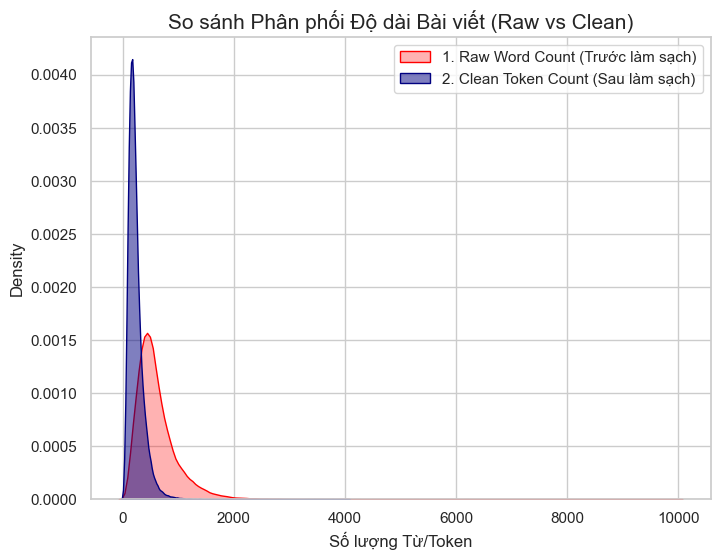

Token trung bình (Raw): 601.18
Token trung bình (Clean): 228.14


In [110]:
df_clean['token_count'] = df_clean['clean_content'].apply(lambda x: len(str(x).split()))


df_filtered = df_clean[df_clean['token_count'] >= 5].copy()
 
plt.figure(figsize=(8, 6))
sns.kdeplot(df_filtered['raw_word_count'], label='1. Raw Word Count (Trước làm sạch)', color='red', fill=True, alpha=0.3)
sns.kdeplot(df_filtered['token_count'], label='2. Clean Token Count (Sau làm sạch)', color='navy', fill=True, alpha=0.5)

plt.title('So sánh Phân phối Độ dài Bài viết (Raw vs Clean)', fontsize=15)
plt.xlabel('Số lượng Từ/Token')
plt.legend()
plt.show()

print(f"Token trung bình (Raw): {df_filtered['raw_word_count'].mean():.2f}")
print(f"Token trung bình (Clean): {df_filtered['token_count'].mean():.2f}")


- Trước làm sạch (Raw): Dữ liệu phân tán rộng, đỉnh thấp, chứng tỏ có nhiều tạp âm (noise) và nhiều bài viết có độ dài khác nhau.

- Sau làm sạch (Clean): Dữ liệu cực kỳ tập trung (đỉnh cao), chứng tỏ quá trình Pre-processing đã loại bỏ thành công lượng lớn "nhiễu" (stop-words, html tags), làm giảm phương sai và đưa các bài viết về một độ dài chuẩn mực hơn.

- Phần diện tích trùng nhau giữa hai đồ thị cho thấy sự thay đổi về mặt cấu trúc là rất lớn.

- Số token của Clean so với Raw giảm đáng kể (228.14 < 601.18). Cho thấy quá trình pre-processing đã giảm số token đáng kể để thuận tiện hơn khi đưa vào mô hình huấn luyện, giúp mô hình học tập nhanh hơn và tốn ít tài nguyên hơn.


### **Phân tích Tần suất từ (Word Frequency)**

In [111]:
def analyze_word_frequency(df, column_name, title, top_n=20):
    word_counts = Counter()

    for text in df[column_name].astype(str):
        word_counts.update(text.split())

    common_words = word_counts.most_common(top_n)

    df_freq = pd.DataFrame(common_words, columns=['Word', 'Count'])

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_freq, x='Count', y='Word', hue='Word', palette='viridis')
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel('Tần suất xuất hiện')
    plt.ylabel('Từ')
    plt.legend([],[], frameon=False)  
    plt.show()

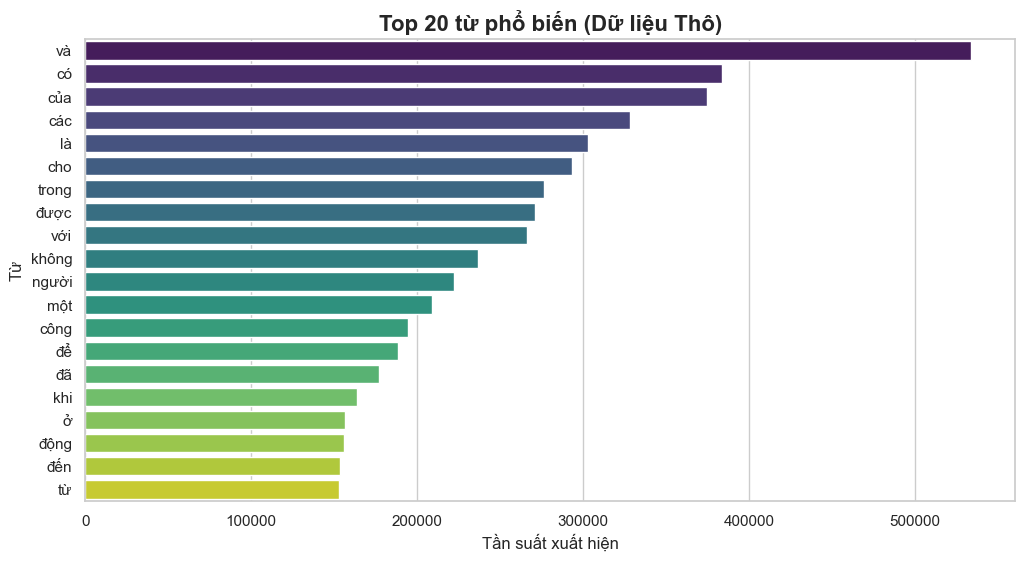

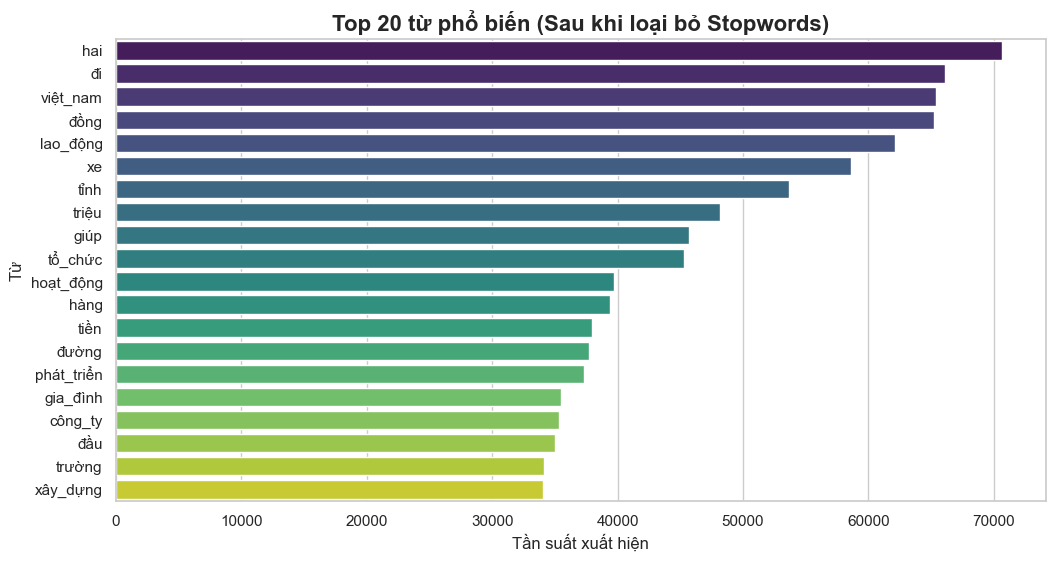

In [112]:
analyze_word_frequency(df_filtered, 'content', 'Top 20 từ phổ biến (Dữ liệu Thô)')
analyze_word_frequency(df_filtered, 'clean_content', 'Top 20 từ phổ biến (Sau khi loại bỏ Stopwords)')

- Sự thay đổi về bản chất từ vựng: Dữ liệu thô (Raw) bị chiếm đa số bởi các hư từ vô nghĩa (và, là, của...), trong khi dữ liệu sạch (Clean) làm nổi bật các thực thể mang ý nghĩa nội dung cụ thể (Việt Nam, công ty, lao động...).

- Giảm thiểu nhiễu (Noise Reduction): Tần suất xuất hiện giảm mạnh từ mức "khổng lồ" (500.000 lần) xuống mức thực tế (70.000 lần), chứng tỏ quá trình loại bỏ Stopwords đã cắt bỏ thành công lớp "tiếng ồn" ngữ pháp lấn át dữ liệu.

- Lộ diện chủ đề (Semantic Signal): Trong khi Top 20 từ thô không cho thấy bất kỳ thông tin gì về nội dung, thì Top 20 từ sạch đã hé lộ rõ các chủ đề chính của tập dữ liệu như Kinh tế (đồng, triệu, công ty) và Xã hội (gia đình, xe, đường).

- Cải thiện ngữ cảnh: Dữ liệu sạch xuất hiện nhiều từ ghép có nghĩa hoàn chỉnh (phát_triển, hoạt_động), thay vì các từ đơn rời rạc, giúp mô hình máy học nắm bắt ngữ cảnh tốt hơn.

### **Phân bố độ dài**

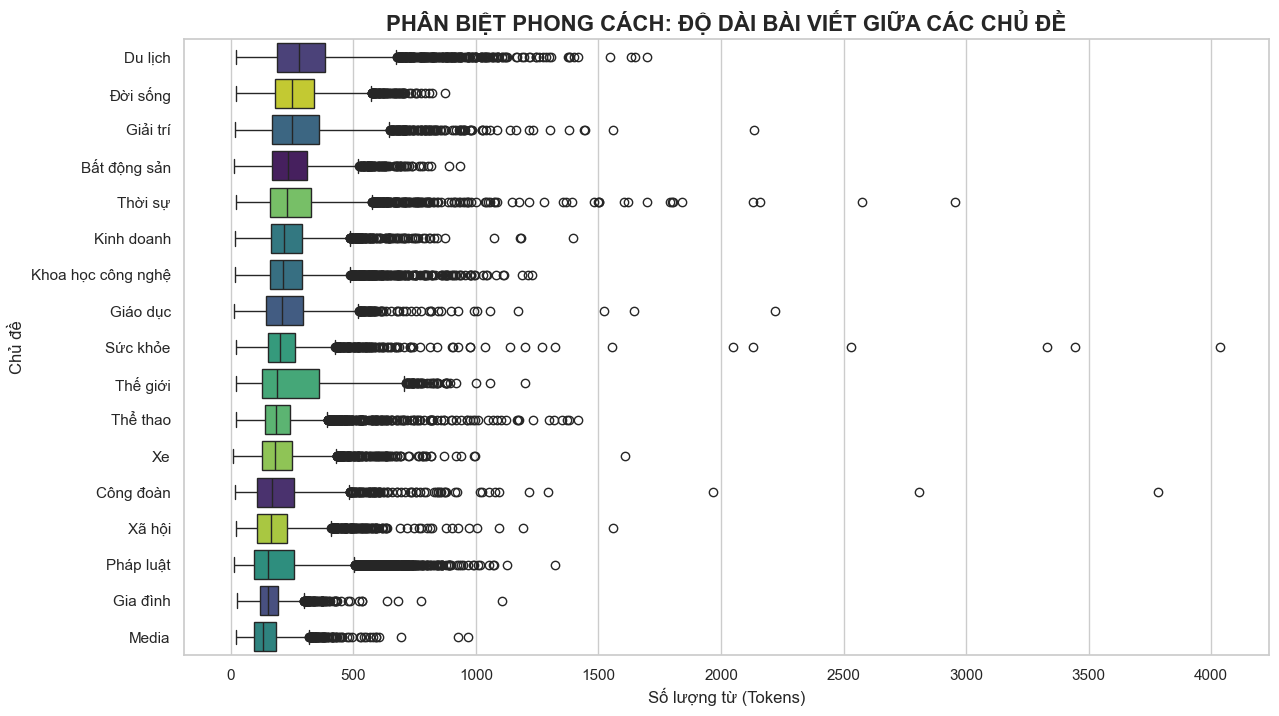

In [113]:
df_filtered['word_count'] = df_filtered['clean_content'].apply(lambda x: len(str(x).split()))

sorted_idx = df_filtered.groupby('category')['word_count'].median().sort_values(ascending=False).index

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_filtered,
    x='word_count',
    y='category',
    hue = 'category',
    order=sorted_idx, 
    palette='viridis'
)

plt.title('PHÂN BIỆT PHONG CÁCH: ĐỘ DÀI BÀI VIẾT GIỮA CÁC CHỦ ĐỀ', fontsize=16, weight='bold')
plt.xlabel('Số lượng từ (Tokens)')
plt.ylabel('Chủ đề')
plt.show()

- Tồn tại sự "bất bình đẳng" rõ rệt về độ dài giữa các nhóm tin.

- Nhóm "Dài": Các chủ đề Du lịch, Giải trí, Thời sự có thân hộp (IQR) dài và nhiều ngoại lai (outliers) phía trên, chứng tỏ các bài viết thường dài và độ biến thiên lớn.

- Nhóm "Ngắn gọn": Các chủ đề Xe, Gia đình, Sức khỏe có thân hộp ngắn, nằm thấp sát trục hoành, cho thấy văn phong súc tích, ngắn gọn.

- Đặc điểm này phản ánh văn phong báo chí (Journalistic Style) đặc thù của từng lĩnh vực. Tin "Du lịch" thường là các bài phóng sự trải nghiệm (long-form), trong khi tin "Xe" hay "Giá vàng" thường chỉ là các thông báo thông số kỹ thuật hoặc bản tin nhanh (short-form).

### **Phân tích N-grams**

* Phân tích này giúp tìm ra các cụm từ (Bigrams, Trigrams) đặc trưng giúp phân loại 17 chủ đề.

In [114]:
def get_top_n_grams(text_series, n=2, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n), max_features=10000)
    
    X = vectorizer.fit_transform(text_series.astype(str))
    
    sum_words = X.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_k]

all_categories = df_filtered['category'].unique()
all_categories_top_ngrams = {}

print(f"Bắt đầu phân tích Top Bigrams (n=2) cho {len(all_categories)} Category...")
for category in all_categories:
    text_category = df_filtered[df_filtered['category'] == category]['clean_content']
    if len(text_category) > 10: 
        top_bigrams = get_top_n_grams(text_category, n=2, top_k=10)
        all_categories_top_ngrams[category] = top_bigrams
        print(f"-> Hoàn thành '{category}'")
    else:
        print(f"--- Bỏ qua Category '{category}' do quá ít dữ liệu. ---")
print("\n" + "="*50)
print("KẾT QUẢ TỔNG HỢP TOP BIGRAMS (N=2)")
print("="*50)

for category, bigrams in all_categories_top_ngrams.items():
    print(f"\n### {category} ###")
    for word, freq in bigrams:
        print(f"- {word}: {freq}")

Bắt đầu phân tích Top Bigrams (n=2) cho 17 Category...
-> Hoàn thành 'Bất động sản'
-> Hoàn thành 'Công đoàn'
-> Hoàn thành 'Du lịch'
-> Hoàn thành 'Gia đình'
-> Hoàn thành 'Giáo dục'
-> Hoàn thành 'Giải trí'
-> Hoàn thành 'Khoa học công nghệ'
-> Hoàn thành 'Kinh doanh'
-> Hoàn thành 'Media'
-> Hoàn thành 'Pháp luật'
-> Hoàn thành 'Sức khỏe'
-> Hoàn thành 'Thế giới'
-> Hoàn thành 'Thể thao'
-> Hoàn thành 'Thời sự'
-> Hoàn thành 'Xe'
-> Hoàn thành 'Xã hội'
-> Hoàn thành 'Đời sống'

KẾT QUẢ TỔNG HỢP TOP BIGRAMS (N=2)

### Bất động sản ###
- chủ đầu_tư: 3269
- triệu đồng: 3264
- tp hcm: 3238
- phòng ngủ: 2812
- tỷ đồng: 2285
- giá đất: 1923
- khu đô_thị: 1623
- khu đất: 1496
- quyền đất: 1299
- không_gian sống: 955

### Công đoàn ###
- triệu đồng: 3365
- lđlđ tỉnh: 3234
- công_nhân lao_động: 1803
- công_đoàn cơ_sở: 1615
- liên_đoàn lao_động: 1597
- phó chủ_tịch: 1596
- tỉ đồng: 1591
- tổ_chức công_đoàn: 1341
- dịch covid: 1336
- chủ_tịch lđlđ: 1277

### Du lịch ###
- chuyến đi: 1981
- tp 

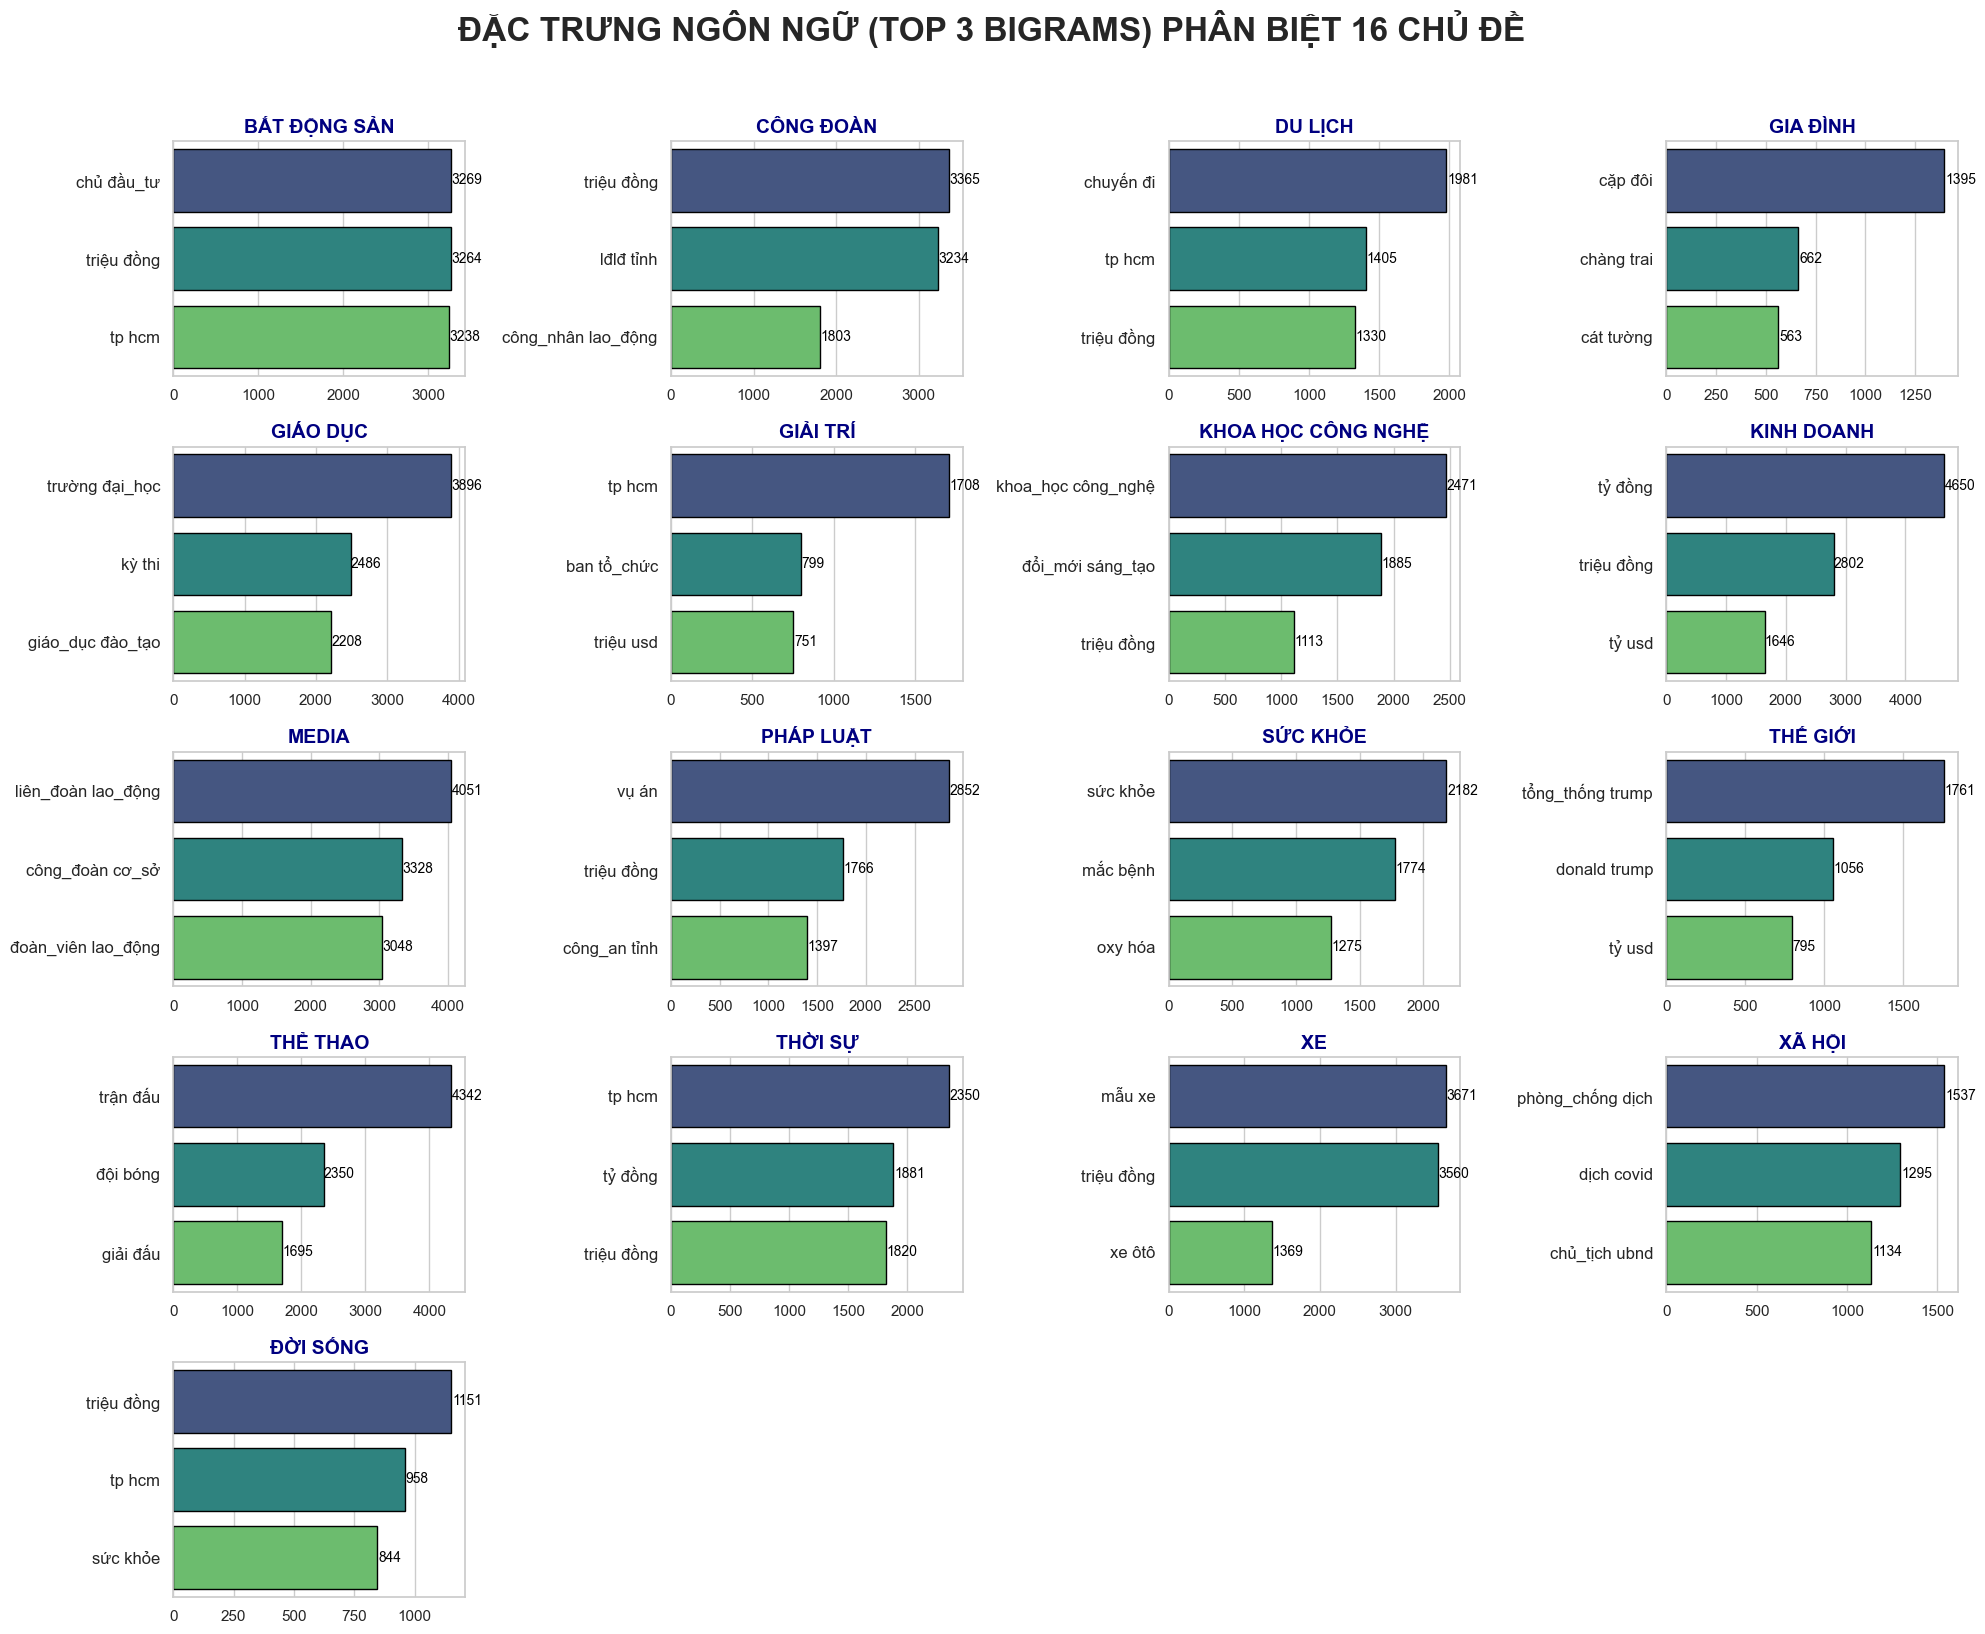

In [115]:
data_list = []
for category, bigrams in all_categories_top_ngrams.items():
    for word, freq in bigrams[:3]:
        data_list.append({'Category': category, 'Bigram': word, 'Frequency': freq})

df_ngrams = pd.DataFrame(data_list)
n_categories = len(df_ngrams['Category'].unique())
n_cols = 4
n_rows = math.ceil(n_categories / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16), sharex=False)
fig.suptitle('ĐẶC TRƯNG NGÔN NGỮ (TOP 3 BIGRAMS) PHÂN BIỆT 16 CHỦ ĐỀ', fontsize=24, y=1.02, weight='bold')
axes_flat = axes.flatten()
unique_categories = df_ngrams['Category'].unique()
for i, category in enumerate(unique_categories):
    ax = axes_flat[i]
    subset = df_ngrams[df_ngrams['Category'] == category]

    sns.barplot(
    data=subset, 
    x='Frequency', 
    y='Bigram', 
    ax=ax, 
    hue='Bigram',       
    palette='viridis',  
    dodge=False,        
    legend=False,      
    edgecolor='black'   
)
  
    ax.set_title(category.upper(), fontsize=14, weight='bold', color='navy')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='y', labelsize=12) 
    for index, value in enumerate(subset['Frequency']):
        ax.text(value + 5, index, f'{value}', va='center', fontsize=10, color='black')

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

- Mình chỉ lựa chọn top 3 bigrams của từng chủ đề để trực quan phân tích (mỗi chủ đề có rất nhiều bigrams)

- Các cặp từ (Bigrams) xuất hiện với tần suất cao nhất hoàn toàn khác biệt giữa các nhóm. Ví dụ: "Bất động sản" gắn liền với chủ đầu tư, triệu đồng, trong khi "Pháp luật" đặc trưng bởi vụ án, công an.

- Điều này chứng tỏ mỗi chủ đề tin tức đều có một bộ từ vựng chuyên ngành (domain-specific vocabulary) riêng biệt, ít bị trùng lặp.

- Các từ định nghĩa rõ nhất cho từng lĩnh vực chủ đề đều có xu hướng tần suất xuất hiện nhiều. Sự khác biệt này là cơ sở vững chắc để mô hình Classification học các đặc trưng (Features) và đảm bảo độ chính xác cao.

### **Word Cloud**

Đang tạo Word Clouds...


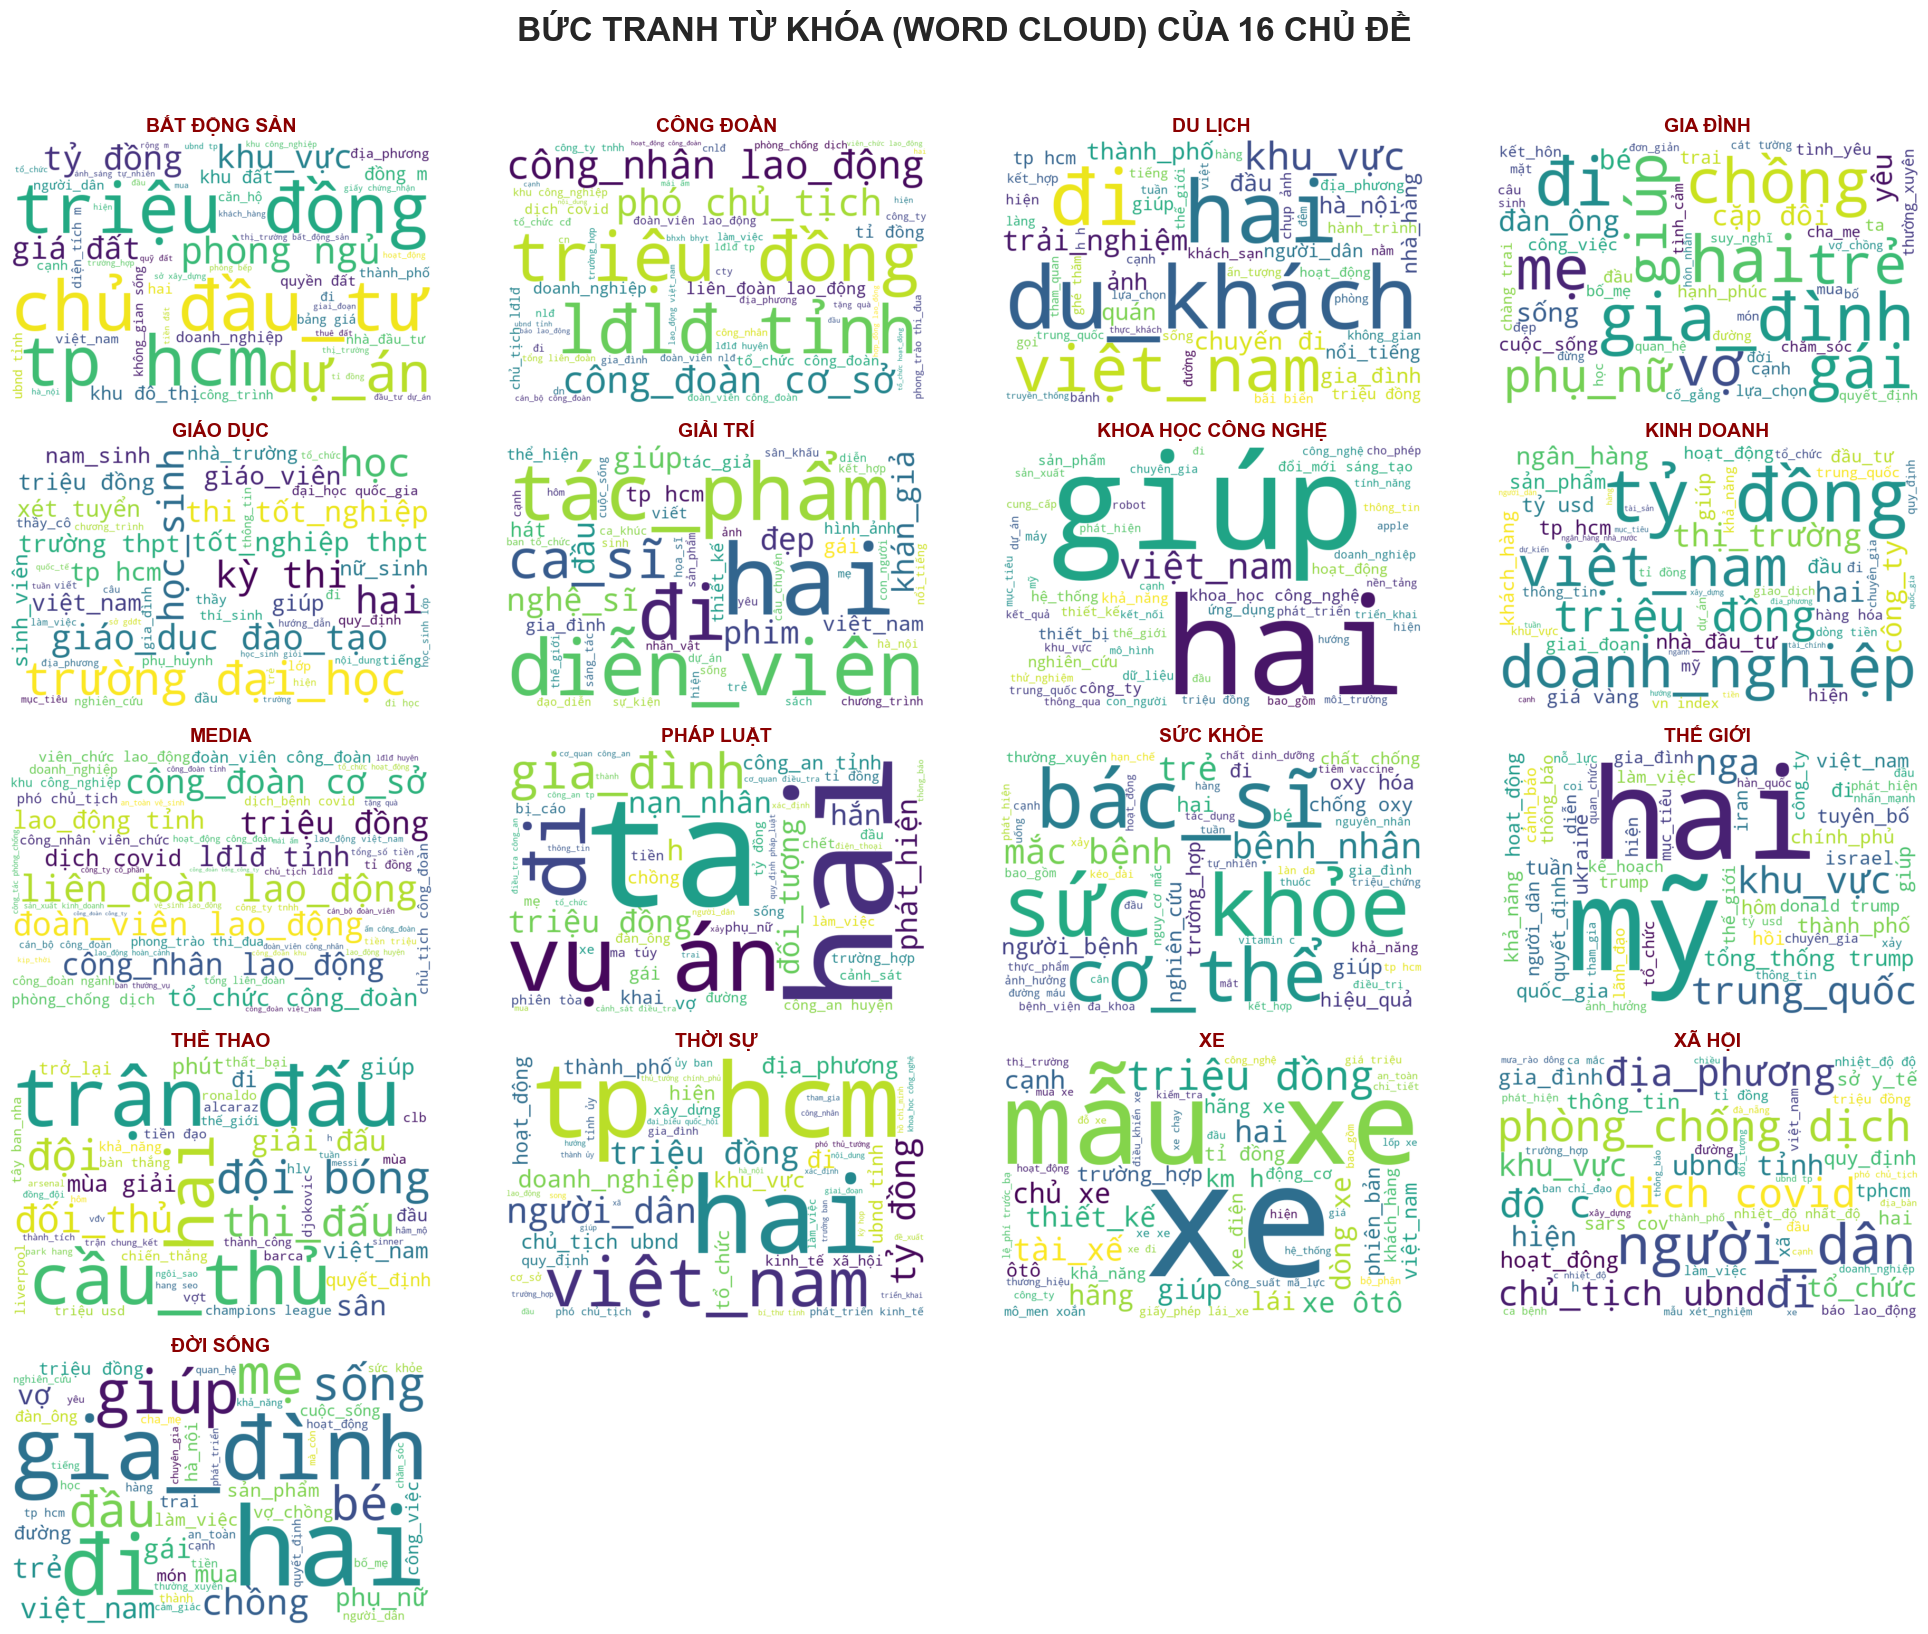

In [116]:
n_categories = len(all_categories)
n_cols = 4
n_rows = math.ceil(n_categories / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 16))
fig.suptitle('BỨC TRANH TỪ KHÓA (WORD CLOUD) CỦA 16 CHỦ ĐỀ', fontsize=24, y=1.02, weight='bold')
axes_flat = axes.flatten()

print("Đang tạo Word Clouds...")
for i, category in enumerate(all_categories):
    ax = axes_flat[i]
    
    text_category = df_filtered[df_filtered['category'] == category]['clean_content']
    text_combined = " ".join(text_category.astype(str))
    
    wc = WordCloud(
        background_color='white', 
        max_words=50,             
        width=800, height=500,
        colormap='viridis'           
    ).generate(text_combined)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(category.upper(), fontsize=14, weight='bold', color='darkred')
    ax.axis('off') 

for j in range(i + 1, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.tight_layout()
plt.show()

- Các từ khóa trọng tâm đặc trưng của từng chủ đề xuất hiện nổi bật và đúng ngữ cảnh (như Bác sĩ trong nhóm Sức khỏe, Trận đấu trong nhóm Thể thao).

- Không còn thấy sự xuất hiện của các từ vô nghĩa, xác nhận quá trình làm sạch dữ liệu (loại bỏ stopwords) đã thực hiện triệt để.

- Các chủ đề chung chung như (đời sống, thời sự) vẫn chứa khá nhiều các từ chung liên quan đến các chủ đề khác --> Vấn đề có thể gây ra nhầm lẫn khi dự đoán

### **Phân tích độ tương đồng chủ đề**

In [117]:
def plot_topic_similarity(df, text_col='clean_content', cat_col='category'):
    print("Đang tính toán ma trận tương đồng...")
    # Gộp văn bản theo chủ đề
    cat_text = df.groupby(cat_col)[text_col].apply(lambda x: " ".join(str(x) for x in x))
    
    # Vector hóa TF-IDF (Lấy 2000 features đặc trưng nhất)
    tfidf = TfidfVectorizer(max_features=2000)
    tfidf_matrix = tfidf.fit_transform(cat_text)
    
    # Tính Cosine Similarity
    sim_matrix = cosine_similarity(tfidf_matrix)
    
    # Vẽ Heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='RdYlBu_r',
                xticklabels=cat_text.index, yticklabels=cat_text.index, vmin=0, vmax=1)
    plt.title('MA TRẬN TƯƠNG ĐỒNG NGỮ NGHĨA GIỮA CÁC CHỦ ĐỀ', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Đang tính toán ma trận tương đồng...


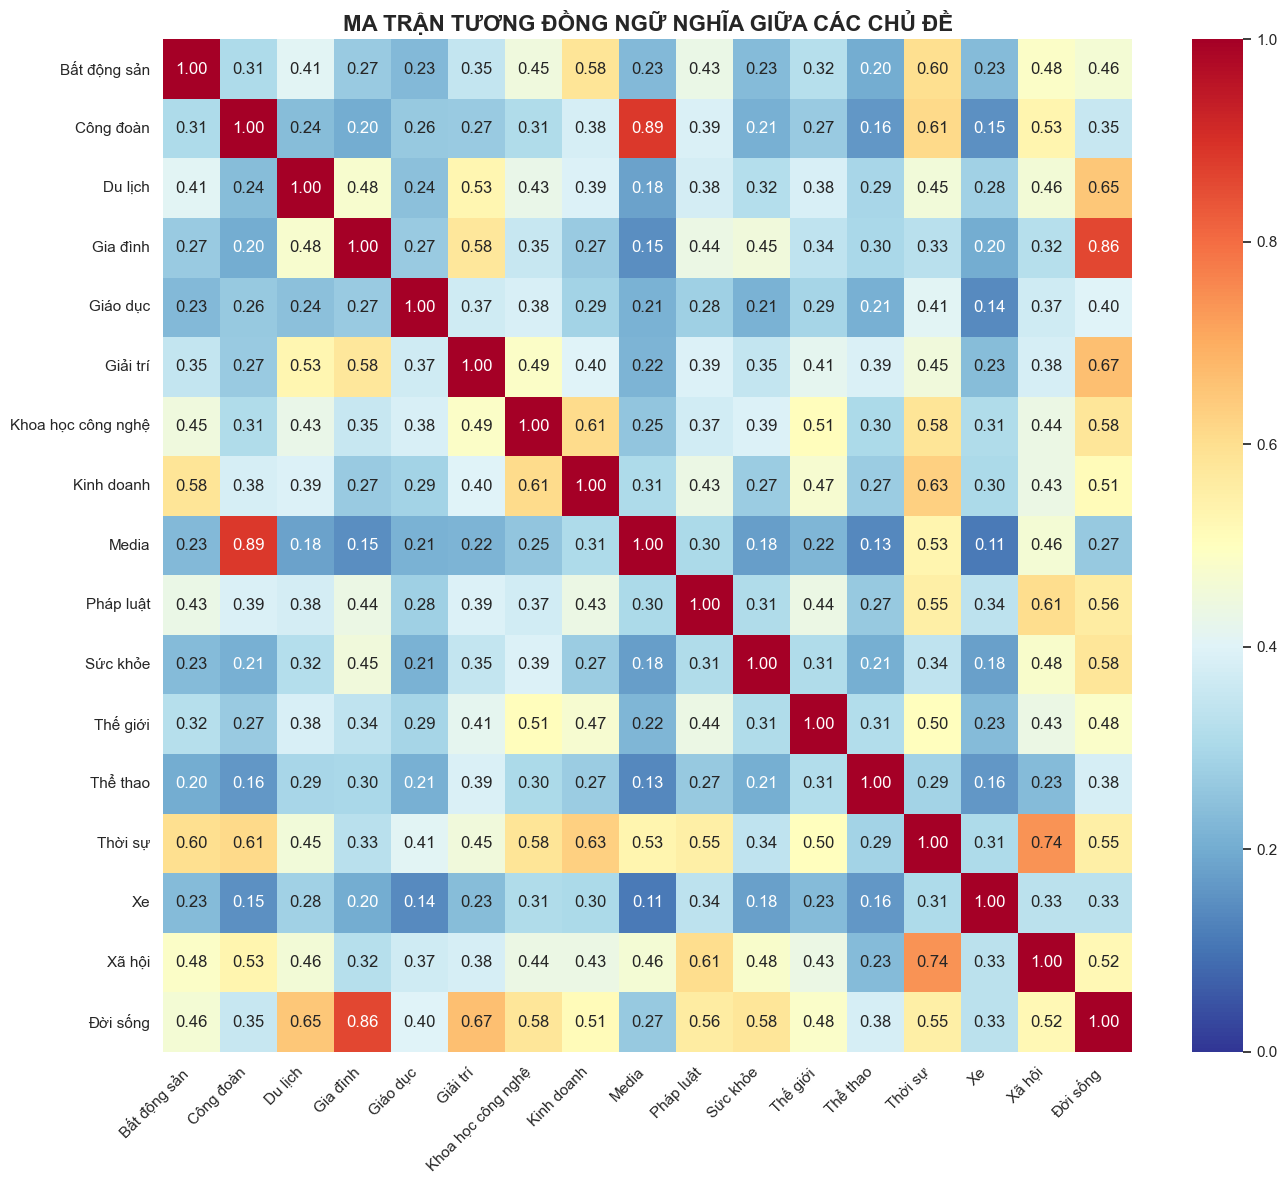

In [118]:
plot_topic_similarity(df_filtered)

- Xuất hiện các cặp nhãn có độ tương đồng rất cao (> 0.8) như Media - Công đoàn (0.89) hay Đời sống - Gia đình (0.86) --> có thể chứa các từ hoặc ngữ cảnh giống nhau. Có thể gây nhầm lẫn.

- Nguyên nhân do các chủ đề này sử dụng chung nhiều từ vựng (ví dụ: tin Công đoàn thường nằm trong mục Xã hội/Media).

- Đây là các "vùng nóng" cảnh báo rủi ro mô hình sẽ dễ bị nhầm lẫn (misclassify) giữa hai nhãn này.

- Tuy nhiên vẫn có các chủ đề không tương đồng nhau thể hiện sự phân biệt rõ rệt (các ô màu xanh chiếm đa số). --> Chứa ngữ cảnh, các từ đặc trưng riêng biệt cho từng chủ đề.

### **Phân tích độ đa dạng từ vựng**

In [119]:
def plot_vocab_entropy(df, text_col='clean_content', cat_col='category'):
    print("Đang tính toán Entropy từ vựng...")
    entropy_data = []
    
    for cat in df[cat_col].unique():
        # Lấy text của 1 category
        text = " ".join(df[df[cat_col] == cat][text_col].astype(str).tolist())
        words = text.split()
        
        # Tính phân phối xác suất của từ
        counts = Counter(words)
        total = sum(counts.values())
        probs = [c/total for c in counts.values()]
        
        # Tính Entropy
        ent = entropy(probs, base=2)
        entropy_data.append({'Category': cat, 'Entropy': ent})
        
    df_ent = pd.DataFrame(entropy_data).sort_values('Entropy', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_ent, x='Entropy', y='Category',hue='Category', palette='magma')
    plt.title('ĐỘ ĐA DẠNG NGÔN NGỮ (ENTROPY) THEO CHỦ ĐỀ', fontsize=16, weight='bold')
    plt.xlabel('Entropy (Bits) - Càng cao càng dùng nhiều từ vựng đa dạng')
    plt.tight_layout()
    plt.show()

Đang tính toán Entropy từ vựng...


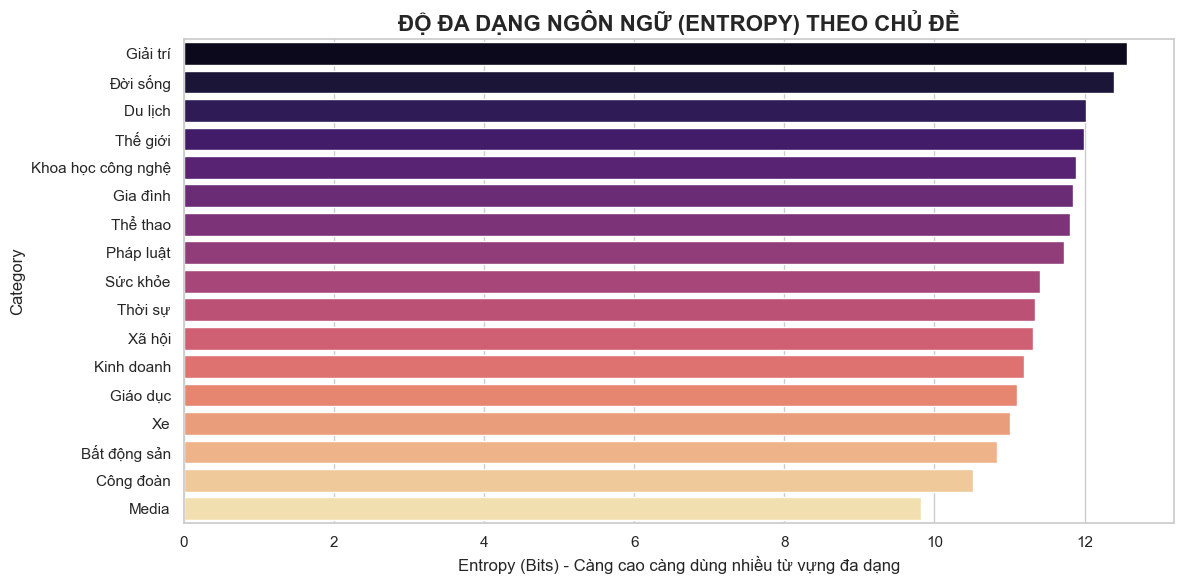

In [120]:
plot_vocab_entropy(df_filtered)

- Có sự chênh lệch lớn về độ phong phú ngôn ngữ: nhóm Giải trí/Du lịch/Đời sống có chỉ số Entropy rất cao, trong khi nhóm Bất động sản/Công đoàn lại thấp.

- Nhóm giải trí dùng văn phong bay bổng, từ vựng rộng; ngược lại nhóm Bất động sản lặp lại nhiều thuật ngữ chuyên môn.

- Nhóm du lịch thì từng địa danh, món ăn đặc trưng vùng hoặc địa điểm đều có cách gọi khác nhau ở từng vùng hoặc tên riêng.

- Nhóm đời sống là một chủ đề chung chung nên có thể chứa nhiều nhóm từ vựng cũng có thể liên quan hoặc chứa các từ vựng của chủ đề khác.

### **Lưu data cho xây dựng mô hình**

In [122]:
df_filtered.to_csv('../Data/vietnamese_news_for_modeling.csv', index=False)